In [96]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, concatenate
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [97]:
import pathlib 
aigenrated_dir = pathlib.Path('aigenrated')
orginal_dir = pathlib.Path('Original')

In [98]:
import numpy as np

dirlist = [aigenrated_dir, orginal_dir]
classes = ['No', 'Yes']
filepaths = []
labels = []

for i, j in zip(dirlist, classes):
    filelist = os.listdir(i)
    for f in filelist:
        filepath = os.path.join(i, f)
        filepaths.append(filepath)
        labels.append(j)  

# Convert labels to numerical values (0 or 1)
label_map = {'No': 0, 'Yes': 1}
labels = np.array([label_map[label] for label in labels], dtype=np.int32)

# Convert filepaths to NumPy array
filepaths = np.array(filepaths)

print("Unique labels after conversion:", np.unique(labels))


Unique labels after conversion: [0 1]


In [99]:
# Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print("Label distribution before split:", unique_labels, counts)

# Ensure stratification works
if len(unique_labels) < 2:
    raise ValueError("Labels contain only one class. Check dataset.")


Label distribution before split: [0 1] [ 3424 42989]


In [ ]:
from sklearn.model_selection import train_test_split

# Re-split the data with stratification
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    filepaths, labels, test_size=0.25, random_state=42, stratify=labels
)

# Further split the temp set into validation and test sets
test_paths, val_paths, test_labels, val_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.3, random_state=42, stratify=temp_labels
)

# Verify the validation set
unique_labels, counts = np.unique(val_labels, return_counts=True)
print("Unique labels in validation set after re-splitting:", unique_labels)
print("Counts:", counts)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")


Unique labels in validation set after re-splitting: [0 1]
Counts: [ 685 8598]
Training samples: 37130
Validation samples: 9283


In [102]:
# Create custom data generators
def generate_data_from_paths(paths, labels, datagen, batch_size, is_training=True):
    num_samples = len(paths)
    while True:
        # Shuffle for training
        if is_training:
            indices = np.random.permutation(num_samples)
            paths = paths[indices]
            labels = labels[indices]
        
        for idx in range(0, num_samples, batch_size):
            batch_paths = paths[idx:idx + batch_size]
            batch_labels = labels[idx:idx + batch_size]
            
            # Load and preprocess images
            batch_images = []
            for path in batch_paths:
                img = tf.keras.preprocessing.image.load_img(
                    path, 
                    target_size=(IMG_SIZE, IMG_SIZE)
                )
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = datagen.random_transform(img) if is_training else img
                img = img / 255.0  
                batch_images.append(img)
            
            yield np.array(batch_images), np.array(batch_labels)

# Define datagen and batch_size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.3,  
    zoom_range=0.3,  
    horizontal_flip=True,
    vertical_flip=True,  
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = 224  
BATCH_SIZE = 32

# Create generators
train_generator = generate_data_from_paths(
    train_paths, train_labels, train_datagen, BATCH_SIZE, is_training=True
)

val_generator = generate_data_from_paths(
    val_paths, val_labels, val_datagen, BATCH_SIZE, is_training=False
)

In [103]:
def create_hybrid_model():
    # Load EfficientNetB0
    efficientnet = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    efficientnet.trainable = False  

    # Load Xception
    xception = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    xception.trainable = False  

    # Input layer
    input_layer = tf.keras.Input(shape=(224, 224, 3))

    # Pass input through both models
    efficientnet_output = efficientnet(input_layer)
    xception_output = xception(input_layer)

    
    efficientnet_pool = GlobalAveragePooling2D()(efficientnet_output)
    xception_pool = GlobalAveragePooling2D()(xception_output)

    
    merged = concatenate([efficientnet_pool, xception_pool])

    
    x = BatchNormalization()(merged)
    x = Dense(128, activation='relu')(x) 
    x = Dropout(0.7)(x)
    output = Dense(1, activation='sigmoid')(x)

   
    model = Model(inputs=input_layer, outputs=output)

    return model

In [104]:
model = create_hybrid_model()

In [105]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [106]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,  
    restore_best_weights=True 
)

In [107]:
history = model.fit(
    train_generator,
    steps_per_epoch=32,  
    validation_data=val_generator,
    validation_steps=len(val_paths) // BATCH_SIZE, 
    epochs=5,  
    callbacks=[early_stopping]  
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1225s 39s/step - accuracy: 0.5900 - loss: 0.9796 - val_accuracy: 0.9270 - val_loss: 0.2056
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1180s 38s/step - accuracy: 0.8974 - loss: 0.3636 - val_accuracy: 0.9429 - val_loss: 0.1476
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1163s 37s/step - accuracy: 0.9155 - loss: 0.2849 - val_accuracy: 0.9416 - val_loss: 0.1298
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1158s 37s/step - accuracy: 0.9160 - loss: 0.2693 - val_accuracy: 0.9453 - val_loss: 0.1144
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1168s 38s/step - accuracy: 0.9304 - loss: 0.1939 - val_accuracy: 0.9613 - val_loss: 0.0937


In [ ]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = generate_data_from_paths(
    test_paths, test_labels, test_datagen, BATCH_SIZE, is_training=False
)

In [ ]:
val_loss, val_accuracy = model.evaluate(test_generator, steps=len(test_paths) // BATCH_SIZE)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

290/290 ━━━━━━━━━━━━━━━━━━━━ 1062s 4s/step - accuracy: 0.9604 - loss: 0.0904
Validation Loss: 0.0938800498843193
Validation Accuracy: 0.9613015055656433


In [114]:
model.save('deepfake_detection_model.h5')

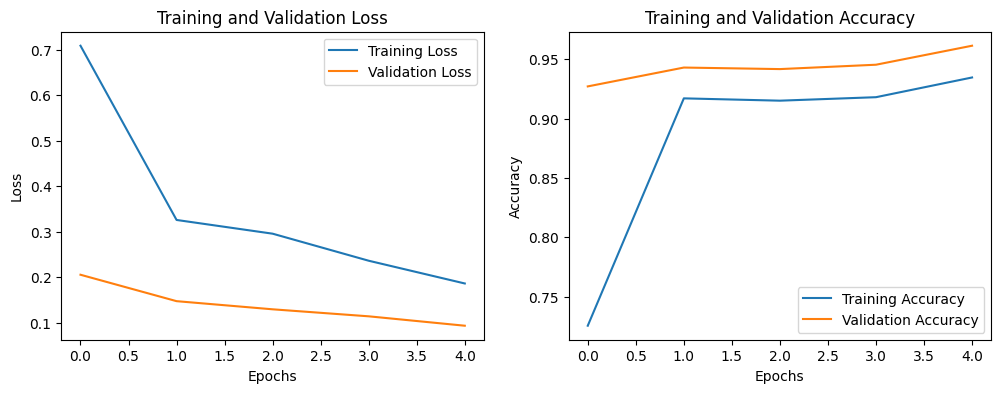

In [115]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()